## Resource estimation for trapped ion systems

##### TODO Pile

###### High priority:
* ~~Fix error correction in conditional teleportation~~
* ~~Implement no-op and CNOT gate level noise~~
* ~~Purification doesn't seem to be improving fidelity much? What's going on here?~~
* add_cnot_error currently not working for the 2 purifier case
* Find out how probability goes with Fidelity for parity check purification.
* Set up Github repository and invite Ilia, Simon and Sri.
* Set up measurement errors for the conditional teleportation

###### Medium priority:
* Despite tuning the Fidelity of the Bell pair, the purification circuit is remarkably consistent... What's going on here?
* Move measurements to the end of the circuit. Is this more than cosmetic? (Possibly, since amplitudes may shift)
* Change H MZ into MX. Is this more than cosmetic?
* Stim's stabilizer has a method "postselect." Is this something we can use?

###### (?) priority:
* Establish how Stim's tableau simulator tracks states. Does the measurement record carry over from experiment to experiment? How do I look at the internal state of the simulator?
* Develop stim code for 2 qubit tomography and test against: 1) an ideal bell pair, 2) a noisy bell pair, 3) The output pair of a single purification circuit, 4) the output of the big circuit. (In practice, we don't actually need to do this, see notes section for clarification)
* Write seperate methods for each of the purification protocol. More of a convenience than a necessity probably, but would be better for debugging maybe...

##### NOTES

Feedforward in Stim: [Possible, but not especially nice](https://quantumcomputing.stackexchange.com/questions/22281/simulating-flag-qubits-and-conditional-branches-using-stim). Gidney indicates at least a 100x slowdown

* Is the difference between M and MR (destructive vs. non-destructive) significant? Yes. MR is measurement reset in a particular basis. To avoid this complication of basis, it's better to measure in whichever basis, then follow immediately with 'R' to reset to logical zero.
* Rather than performing 2 qubit tomography on the output pair, Simon pointed out that we can use Stim's simulator.statevector() method, calculate inner product with respect to a noiseless bell pair, and sample a few thousand times to get average fidelity. Much easier, but does scale exponentially
* The bottom two qubits in the big circuit aren't currently coded to have any noise. Is this a reasonable assumption?

In [1]:
import stim
import numpy as np
import itertools
from copy import copy
from copy import deepcopy
from random import random
import sys
import matplotlib.pyplot as plt

In [2]:
"""
Get the amplitudes of the output statevector corresponding to a Bell state in the last two qubits of the big circuit.
Right now this is for easier readability in the debug mode for large states
"""
def get_bell_amps(state_vector, num_purifiers):
    # Note: stim statevector is little endian
    zero_zero = state_vector[0]
    num_qubits = 4 * num_purifiers + 2
    one_one = state_vector[2**(num_qubits-1) + 2**(num_qubits-2)]
    return [zero_zero, one_one]

# Other options: 
#      Print all non-zero entries of the statevector with corresponding amplitudes  

In [3]:
# Create a statevector for 4 * num_purifers + 2 qubit system such that the last 2 qubits contain an ideal Bell Pair
def ideal_sv(num_purifiers):
    # Note: stim statevector is little endian
    num_qubits = 4 * num_purifiers + 2
    sv = np.zeros(2 ** num_qubits, complex)
    sv[0] = 1/np.sqrt(2)
    sv[2**(num_qubits-1) + 2**(num_qubits-2)] = 1/np.sqrt(2)
    return sv

# Sanity check
n = 1
print(ideal_sv(n))
print(get_bell_amps(ideal_sv(n), n))

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
[(0.7071067811865475+0j

H 0
DEPOLARIZE1(0.8) 1 2 3
CX 0 1
DEPOLARIZE1(0.8) 2 3
Y 0 2
DEPOLARIZE1(0.8) 1 3
CX 0 1 2 3
SWAP 1 2
DEPOLARIZE1(0.8) 0 3


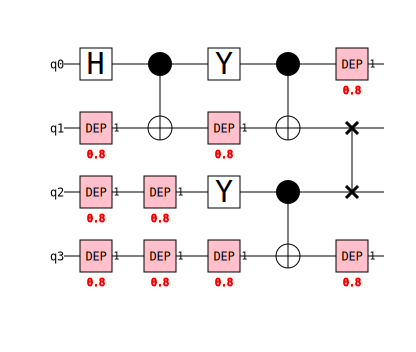

In [4]:
"Parse a stim circuit and add single qubit depolarizing errors for each no-op in the circuit"
def add_identity_error(circuit, prob):
    new_circuit = stim.Circuit()
    # Get the number of qubits in the circuit
    num_qubits = circuit.num_qubits
    for op in circuit:
        new_circuit.append(op)
        qubits = set(range(num_qubits))
        active_qubits = set([x.value for x in op.targets_copy()])
        noop_qubits = list(qubits.difference(active_qubits))
        if len(noop_qubits) > 0: new_circuit.append("DEPOLARIZE1", noop_qubits, prob)
    return new_circuit


test = stim.Circuit()
test.append("H", 0)
test.append("CNOT", [0,1])
test.append("Y", [0,2])
test.append("CNOT", [0,1,2,3])
test.append("SWAP",[1,2])
test_with_error = add_identity_error(test, 0.8)
print(test_with_error)
test_with_error.diagram(type="timeline-svg")

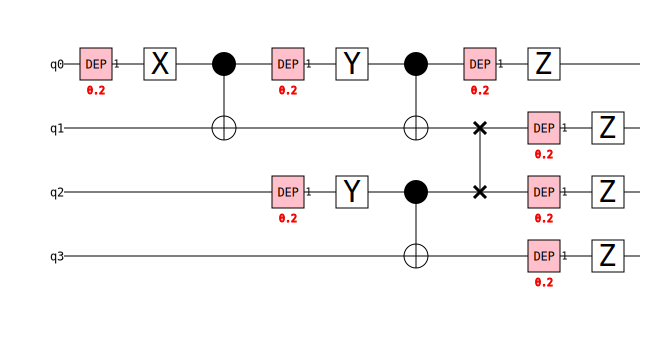

In [5]:
"Parse a stim circuit and add single qubit depolarizing errors BEFORE each single qubit gate"
def add_1gate_error(circuit, prob, gates_with_error=["X", "Y", "Z"]):
    new_circuit = stim.Circuit()
    # Get the number of qubits in the circuit
    num_qubits = circuit.num_qubits
    for op in circuit:
        strop = op.__str__() # op to string
        gate_arg = strop.split()[0] # Filter out first argument
        if gate_arg in set(gates_with_error):
            error_qubits = strop.split()[1:] # list of strings
            error_qubits = [eval(i) for i in error_qubits] # list of ints
            if len(error_qubits) > 0: new_circuit.append("DEPOLARIZE1", error_qubits, prob)
        new_circuit.append(op)
    return new_circuit


test = stim.Circuit()
test.append("X", 0)
test.append("CNOT", [0,1])
test.append("Y", [0,2])
test.append("CNOT", [0,1,2,3])
test.append("SWAP",[1,2])
test.append("Z",[0,1,2,3])
test_with_error = add_1gate_error(test, 0.2)
# print(test_with_error)
test_with_error.diagram(type="timeline-svg")

H 0 2
DEPOLARIZE2(0.8) 0 1 2 3 1 2
CX 0 1 2 3 1 2


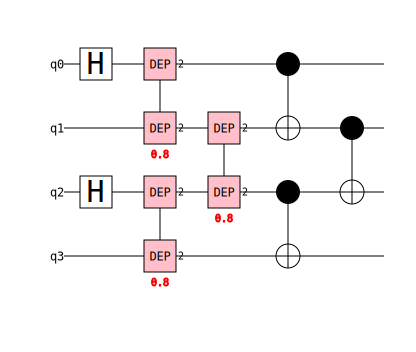

In [6]:
"""
Parse a Stim circuit and add 2-qubit depolarizing error BEFORE each CNOT
TODO: Check and see if there's any reason to do before and not after?
"""
def add_cnot_error(circuit, prob):
    new_circuit = stim.Circuit()
    num_qubits = circuit.num_qubits
    for op in circuit:
        strop = op.__str__() # op to string
        if strop[0:2] == 'CX':
            cnot_qubits = strop[3::].split() # list of strings
            cnot_qubits = [eval(i) for i in cnot_qubits] # list of ints
            if len(cnot_qubits) > 0: new_circuit.append("DEPOLARIZE2", cnot_qubits, prob)
        new_circuit.append(op)
    return new_circuit

test = stim.Circuit()
test.append("H", [0, 2])
test.append("CNOT", [0,1,2,3])
test.append("CNOT", [1,2])
# test.append("CNOT", [3,4])
test_with_error = add_cnot_error(test, 0.8)
print(test_with_error)
test_with_error.diagram(type="timeline-svg")

In [7]:
def add_measurement_error(measurements, prob):
    new_measurements = []
    error_locations = []
    for idx, m in enumerate(measurements):
        if random() <= prob:
            new_measurements.append(not m)
            error_locations.append(idx)
        else:
            new_measurements.append(m)
    return new_measurements, error_locations

print(add_measurement_error([True, False, True], 1.0))
print(add_measurement_error([True, False, True], 0.0))
print(add_measurement_error([True, False, True], 0.5))

([False, True, False], [0, 1, 2])
([True, False, True], [])
([False, True, True], [0, 1])


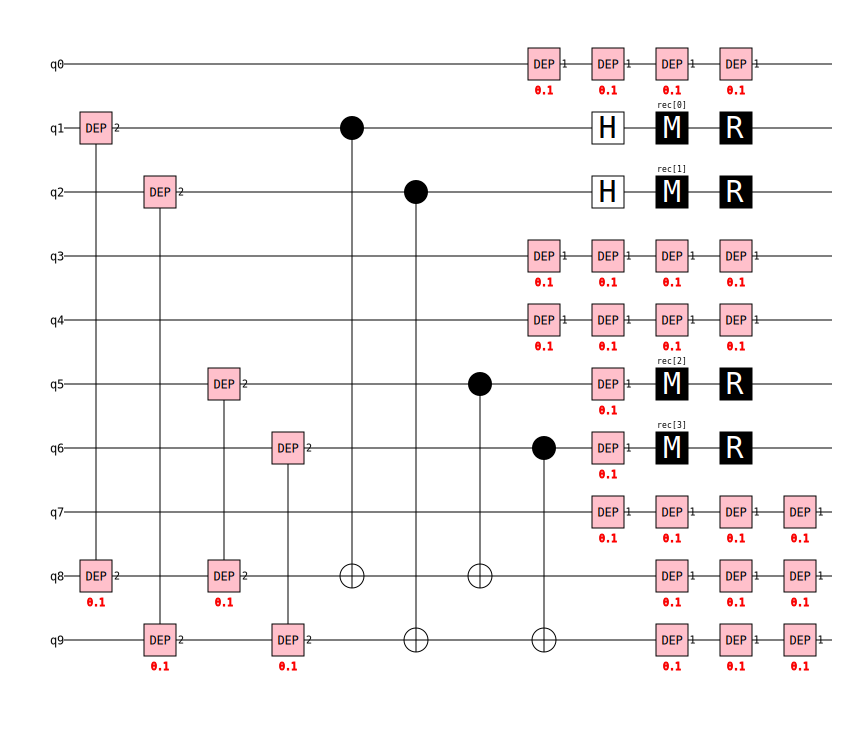

In [8]:
# debug
num_purifiers = 2
qubits = range(4*num_purifiers)
purif_tops = qubits[::4]
pair_to_teleport = [1,2]
ierr = 0.1
cnot_err = 0.1

tele_circuit = stim.Circuit()
outanc = range(qubits[-1]+1, qubits[-1]+3)
for q in purif_tops:
    tele_circuit.append_operation("CNOT", [q+1, outanc[0]])
    tele_circuit.append_operation("CNOT", [q+2, outanc[1]])
tele_circuit.append("H", pair_to_teleport)
for q in purif_tops:
    tele_circuit.append_operation("M", [q+1, q+2])
for q in purif_tops:
    tele_circuit.append_operation("R", [q+1, q+2])
# Add circuit level errors for teleportation
if ierr > 0: tele_circuit = add_identity_error(tele_circuit, ierr)
if cnot_err >0: tele_circuit = add_cnot_error(tele_circuit, cnot_err)
    
tele_circuit.diagram(type="timeline-svg")

Num qubits in purification step: 8
Simulator statevector at initialization:
[1.+0.j]

Simulator statevector after purification:
[0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +

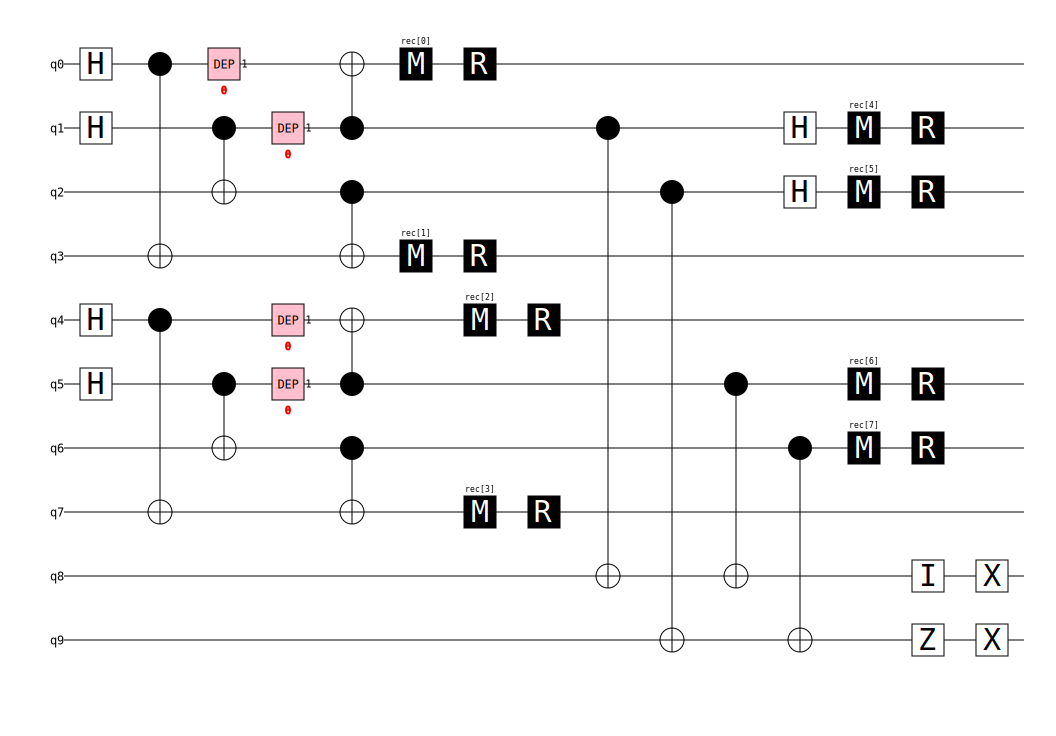

In [9]:
"""
Given a number of 'purifiers' (4 communication ions with loaded entanglement), estimate the fidelity of the output pair
"""
def simulate_protocol(num_purifiers=1, F=1, ierr=0.0, cnot_err=0.0, single_gate_err=0.0, measurement_err=0.0, debug=False):
    circuit = stim.Circuit()
    qubits = range(4*num_purifiers)
    pair_tops = qubits[::2]
    purif_tops = qubits[::4] # top qubit of each purification circuit
    
    # Bell pair constructors (Unfortunately, these seperate loops are necessary to parallelize circuit ops)
    for q in purif_tops:
        circuit.append_operation("H", [q, q+1])
    for q in purif_tops:
        circuit.append_operation("CNOT", [q, q+3])
    for q in purif_tops:
        circuit.append_operation("CNOT", [q+1, q+2])
    for q in purif_tops:
        circuit.append_operation("DEPOLARIZE1", [q, q+1], [1-F])
        
    # Purification circuits
    for q in purif_tops:
        circuit.append_operation("CNOT", [q+1, q, q+2, q+3])
    
    # Add circuit-level errors
    if ierr > 0: circuit = add_identity_error(circuit, ierr)
    if cnot_err > 0: circuit = add_cnot_error(circuit, cnot_err)
    
    for q in purif_tops:
        circuit.append_operation("M", [q, q+3])
        circuit.append_operation("R", [q, q+3])
    if debug: print(f"Num qubits in purification step: {circuit.num_qubits}")
    
    # Run first part of circuit to get purification outcomes
    simulator = stim.TableauSimulator()
    
    if debug: print(f"Simulator statevector at initialization:\n{simulator.state_vector()}\n");
    simulator.do(circuit)
    if debug: print(f"Simulator statevector after purification:\n{simulator.state_vector()}\n");
    
    results = simulator.current_measurement_record()
    # Add measurement errors:
    if measurement_err > 0.0: 
        results, error_locations = add_measurement_error(results, measurement_err)
        if debug: print(f"Measurement errors at locations: {error_locations}")
    
    if debug: print(f"Purifcation measurements: {results}")
    # TODO: Check statistics. Does the probability change with Fidelity? Bennett seems to indicate yes, but need confirmation
    
    # Track succesful pairs
    purified_pairs = []
    m_locs = range(2*num_purifiers) # measurement locations
    for m in m_locs[::2]:
        if results[m] == results[m+1]:
            purified_pairs.extend([2*m+1, 2*m+2]) # extend is append but for multiple entries
    if debug: print(f"purified pairs: {purified_pairs}");
    
    if len(purified_pairs) == 0:
        if debug: print("Purification unsuccessful!")
        return stim.Circuit(), stim.TableauSimulator(), []
    
    # else, choose the first availible pair to teleport
    pair_to_teleport = [purified_pairs[0], purified_pairs[1]]
    if debug: print(f"teleporting pair: {pair_to_teleport}");
    
    # Conditional teleportation
    tele_circuit = stim.Circuit()
    outanc = range(qubits[-1]+1, qubits[-1]+3)
    for q in purif_tops:
        tele_circuit.append_operation("CNOT", [q+1, outanc[0]])
        tele_circuit.append_operation("CNOT", [q+2, outanc[1]])
    tele_circuit.append("H", pair_to_teleport)
    for q in purif_tops:
        tele_circuit.append_operation("M", [q+1, q+2])
    for q in purif_tops:
        tele_circuit.append_operation("R", [q+1, q+2])
    if debug: print(f"num qubits in teleportation step: {tele_circuit.num_qubits}")
    # Add circuit level errors for teleportation
    if ierr > 0: tele_circuit = add_identity_error(tele_circuit, ierr)
    if cnot_err >0: tele_circuit = add_cnot_error(tele_circuit, cnot_err)
    
    # Run teleportation
    simulator.do(tele_circuit)
    results = simulator.current_measurement_record()
    if debug: print(f"Measurement record at teleportation step: {results}")
#     if debug:
#         print(f"\nBell-pair amplitudes on last two qubits (Before correction): {get_bell_amps(simulator.state_vector(), num_purifiers)}\n")
        # with np.printoptions(threshold=sys.maxsize): 
        #    print(f"Simulator statevector after teleportation:\n{simulator.state_vector()}\n");
    circuit.__iadd__(tele_circuit)
    
    # Find measurement indices for the pair to be teleported
    num_prev_measures = 2*num_purifiers # How many measurements circuit pt 1?
    which_purif = int((pair_to_teleport[0] - 1)/4) # which purifier is pair located in?
    pair_mlocs = [num_prev_measures + 2*which_purif, num_prev_measures + 2*which_purif + 1]
    if debug: print(f"which_purif: {which_purif}\nmeasurement indices for teleporting pair: {pair_mlocs}");
    
    # Apply corrections for conditional teleportation
    corrections = stim.Circuit()
    
    # NB: Measurement of 0 == False, Measurement of 1 == True ?
    tf = {True:0, False:1}
    even_mlocs = range(2*num_purifiers, 4*num_purifiers)[::2] # Every other measurement location
    for m in even_mlocs:
        m_tup = [m, m+1]
        if debug: print(f"measurements on pair {m_tup} := {results[m_tup[0]], results[m_tup[1]]}")
        if m_tup == pair_mlocs:
            # Z measurements
            corrections.append("Z", outanc[0]) if results[m_tup[0]] else corrections.append("I", outanc[0]);
            corrections.append("Z", outanc[1]) if results[m_tup[1]] else corrections.append("I", outanc[1]);
        else:
            # X measurements
            corrections.append("X", outanc[0]) if results[m_tup[0]] else corrections.append("I", outanc[0]);
            corrections.append("X", outanc[1]) if results[m_tup[1]] else corrections.append("I", outanc[1]);
            
    # Apply circuit level error for single gates in correction
    if single_gate_err > 0: corrections = add_1gate_error(corrections, single_gate_err)
    
    # Run corrections
    simulator.do(corrections)
    circuit.__iadd__(corrections)
    
    if debug:
        print(f"\nBell-pair amplitudes on last two qubits (After correction): {get_bell_amps(simulator.state_vector(), num_purifiers)}\n")
        # with np.printoptions(threshold=sys.maxsize): 
        #    print(f"Simulator statevector after teleportation:\n{simulator.state_vector()}\n");
    
    teleported_pair = [outanc[0], outanc[1]]
    if debug: print(f"teleported_pair := {teleported_pair}")
        
    return circuit, simulator, teleported_pair

big_circuit, simulator, teleported_pair = simulate_protocol(num_purifiers=2, F=1., ierr=0.00, cnot_err=0.00, 
                                                         single_gate_err=0.00, measurement_err=0.0, debug=True)
big_circuit.diagram(type="timeline-svg")

In [10]:
"""
Calculate the inner product between the ideal bell statevector and the true output
"""
def bell_fidelity(state_vector, num_purifers):
    ideal_state_vector = ideal_sv(num_purifers)
    return np.inner(state_vector, ideal_state_vector)

In [33]:
def average_pair_fidelity(num_trials, num_purifiers, error_probs, quiet=False):
    ave_fidelity = 0
    num_misses = 0
    for i in range(num_trials):
        if quiet == False and i % 100 == 0: print(f"Running trial {i}")
        big_circuit, simulator, teleported_pair = simulate_protocol(num_purifiers=num_purifiers, 
                                                                    F = error_probs["F"], 
                                                                    ierr = error_probs["ierr"], 
                                                                    cnot_err = error_probs["cnot_err"],
                                                                    single_gate_err = error_probs["single_gate_err"], 
                                                                    measurement_err = error_probs["measurement_err"], 
                                                                    debug=False)
        if len(teleported_pair) == 0:
            num_misses += 1
        else:
            state_vector =  simulator.state_vector()
            F = bell_fidelity(state_vector, num_purifiers)
            ave_fidelity += F
    ave_fidelity = ave_fidelity / (num_trials - num_misses)
    return ave_fidelity

In [41]:
err1 = {
    "F":0.90,
    "ierr":0.,
    "cnot_err":0.,
    "single_gate_err":0.,
    "measurement_err":0.
}
average_pair_fidelity(num_trials = 1000, num_purifiers=2, error_probs=err1, quiet=False)

Running trial 0
Running trial 100
Running trial 200
Running trial 300
Running trial 400
Running trial 500
Running trial 600
Running trial 700
Running trial 800
Running trial 900


(0.9380710499354377+0j)

Sampling for p = 0.0
Running trial 0
Running trial 100
Running trial 200
Running trial 300
Running trial 400
Sampling for p = 0.05
Running trial 0
Running trial 100
Running trial 200
Running trial 300
Running trial 400
Sampling for p = 0.1
Running trial 0
Running trial 100
Running trial 200
Running trial 300
Running trial 400
Sampling for p = 0.15000000000000002
Running trial 0
Running trial 100
Running trial 200
Running trial 300
Running trial 400
Sampling for p = 0.2
Running trial 0
Running trial 100
Running trial 200
Running trial 300
Running trial 400
Sampling for p = 0.25
Running trial 0
Running trial 100
Running trial 200
Running trial 300
Running trial 400
Sampling for p = 0.30000000000000004
Running trial 0
Running trial 100
Running trial 200
Running trial 300
Running trial 400
Sampling for p = 0.35000000000000003
Running trial 0
Running trial 100
Running trial 200
Running trial 300
Running trial 400
Sampling for p = 0.4
Running trial 0
Running trial 100
Running trial 200
Runni

/home/hudson/anaconda3/envs/qiskit_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


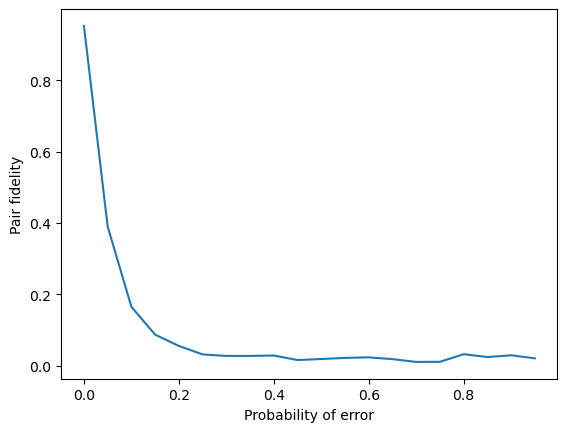

In [13]:
def plot_fidelity_with_error(num_trials):
    num_purifiers = 2
    error_probabilities = np.arange(0., 1., 0.05)
    fidelities = []
    for p in error_probabilities:
        print(f"Sampling for p = {p}")
        fidelity = average_pair_fidelity(num_trials, num_purifiers, p)
        fidelities.append(fidelity)
        
    plt.plot(error_probabilities, fidelities)
    plt.xlabel("Probability of error")
    plt.ylabel("Pair fidelity")
    plt.show()
    return

plot_fidelity_with_error(500)

/home/hudson/anaconda3/envs/qiskit_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/hudson/anaconda3/envs/qiskit_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/hudson/anaconda3/envs/qiskit_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/hudson/anaconda3/envs/qiskit_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/hudson/anaconda3/envs/qiskit_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imagi

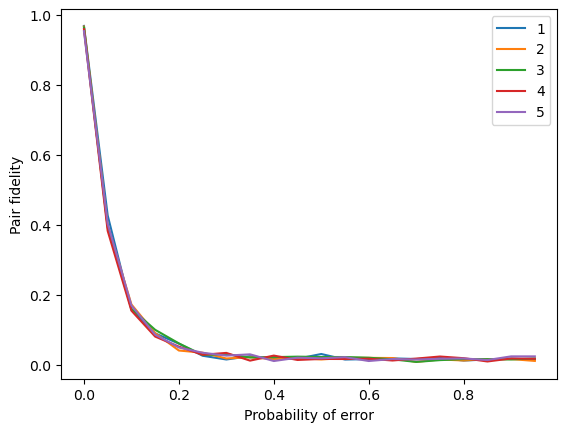

In [31]:
def plot_fidelity_for_variable_purifiers(num_trials):
    max_purifiers = 5
    error_probabilities = np.arange(0., 1., 0.05)
    fidelities = [[] for i in range(1, max_purifiers + 1)]
    for i in range(max_purifiers):
        print(f"Collecting data for num_purifiers = {i+1}")
        for p in error_probabilities:
            fidelity = average_pair_fidelity(num_trials, num_purifiers, p, quiet=True)
            fidelities[i].append(fidelity)
    
    for idx, fs in enumerate(fidelities):
        plt.plot(error_probabilities, fs, label=f"{idx + 1}")
    plt.xlabel("Probability of error")
    plt.ylabel("Pair fidelity")
    plt.legend()
    plt.show()
    return

plot_fidelity_for_variable_purifiers(1000)